# This notebook is for smart home

In [3]:
!pip install tensorflow==2.8.0

Giving Access to the drive via the notebook

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Check GPU status

In [5]:
!nvidia-smi

Wed Oct 11 06:29:31 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   54C    P8    11W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Import the helper functions

In [6]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2023-10-11 06:29:31--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.108.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2023-10-11 06:29:32 (97.6 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [7]:
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, compare_historys, walk_through_dir

## Import dataset

In [8]:
train_dir = "/content/drive/MyDrive/Smart_house/Data/training"
test_dir = "/content/drive/MyDrive/Smart_house/Data/test"

## Get information about the dataset

In [9]:
walk_through_dir('/content/drive/MyDrive/Smart_house/Data')

There are 2 directories and 0 images in '/content/drive/MyDrive/Smart_house/Data'.
There are 3 directories and 0 images in '/content/drive/MyDrive/Smart_house/Data/test'.
There are 0 directories and 66 images in '/content/drive/MyDrive/Smart_house/Data/test/A'.
There are 0 directories and 60 images in '/content/drive/MyDrive/Smart_house/Data/test/B'.
There are 0 directories and 60 images in '/content/drive/MyDrive/Smart_house/Data/test/C'.
There are 3 directories and 0 images in '/content/drive/MyDrive/Smart_house/Data/training'.
There are 0 directories and 247 images in '/content/drive/MyDrive/Smart_house/Data/training/A'.
There are 0 directories and 240 images in '/content/drive/MyDrive/Smart_house/Data/training/B'.
There are 0 directories and 240 images in '/content/drive/MyDrive/Smart_house/Data/training/C'.


## Setup data inputs

In [10]:
import tensorflow as tf

IMG_SIZE = (224, 224)

train_data = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    label_mode="categorical",
    image_size=IMG_SIZE
)

test_data = tf.keras.preprocessing.image_dataset_from_directory(
    test_dir,
    label_mode="categorical",
    image_size=IMG_SIZE,
    shuffle=False
)

Found 240 files belonging to 3 classes.
Found 60 files belonging to 3 classes.


# Training the model

In [11]:
# Adding model checkpoint
checkpoint_path = "model_1_checkpoint"
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                         save_weights_only=True,
                                                         monitor="val_accuracy",
                                                         save_best_only=True)

In [12]:
# Create a data augmentation layer to build data augmentation right into the model
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.models import Sequential

# setup data augmentation
data_augmentation = Sequential([
    preprocessing.RandomFlip("horizontal"),
    preprocessing.RandomRotation(0.2),
    preprocessing.RandomHeight(0.2),
    preprocessing.RandomWidth(0.2),
    preprocessing.RandomZoom(0.2),
    #preprocessing.Rescale(1/255.) # DOES NOT NEEDED SINCE EFFIENETB0 HAS BUILT IN
], name="data_augmentation")

In [13]:
# setup the base model and frezee its layers (this will extract features)
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

# setup model architecture with trainable top layers
inputs = layers.Input(shape=(224,224,3), name="input_layer")
x = data_augmentation(inputs) # augment images (only happens in training phase)
x = base_model(x, training=False) # weights will be frozen
x = layers.GlobalAveragePooling2D(name="Global_average_pooling_layer")(x)
outputs = layers.Dense(len(train_data.class_names), activation="softmax", name="output_layer")(x)
batch2_model_1 = tf.keras.Model(inputs, outputs)

16719872/16705208 [==============================] - 2s 0us/step


In [14]:
batch2_model_1.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation (Sequenti  (None, 224, 224, 3)      0         
 al)                                                             
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 Global_average_pooling_laye  (None, 1280)             0         
 r (GlobalAveragePooling2D)                                      
                                                                 
 output_layer (Dense)        (None, 3)                 3843      
                                                                 
Total params: 4,053,414
Trainable params: 3,843
Non-trainable

In [15]:
# compile
batch2_model_1.compile(loss="categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])

# fit the model
batch2_model_1_history = batch2_model_1.fit(train_data,
                            epochs=30,
                            validation_data=test_data,
                            validation_steps=int(len(test_data)),
                            callbacks=[checkpoint_callback])

Epoch 1/30
8/8 [==============================] - 145s 4s/step - loss: 0.9148 - accuracy: 0.6250 - val_loss: 0.5206 - val_accuracy: 0.9833
Epoch 2/30
8/8 [==============================] - 28s 942ms/step - loss: 0.3771 - accuracy: 0.9708 - val_loss: 0.2100 - val_accuracy: 1.0000
Epoch 3/30
8/8 [==============================] - 27s 1s/step - loss: 0.1883 - accuracy: 0.9917 - val_loss: 0.1051 - val_accuracy: 1.0000
Epoch 4/30
8/8 [==============================] - 25s 799ms/step - loss: 0.1094 - accuracy: 0.9958 - val_loss: 0.0650 - val_accuracy: 1.0000
Epoch 5/30
8/8 [==============================] - 26s 1s/step - loss: 0.0769 - accuracy: 1.0000 - val_loss: 0.0466 - val_accuracy: 1.0000
Epoch 6/30
8/8 [==============================] - 24s 797ms/step - loss: 0.0587 - accuracy: 1.0000 - val_loss: 0.0365 - val_accuracy: 1.0000
Epoch 7/30
8/8 [==============================] - 25s 1s/step - loss: 0.0444 - accuracy: 1.0000 - val_loss: 0.0306 - val_accuracy: 1.0000
Epoch 8/30
8/8 [========

Evaluating the Model

In [16]:
feature_extraction_result = batch2_model_1.evaluate(test_data)
feature_extraction_result

2/2 [==============================] - 4s 2s/step - loss: 0.0052 - accuracy: 1.0000


[0.005224092863500118, 1.0]

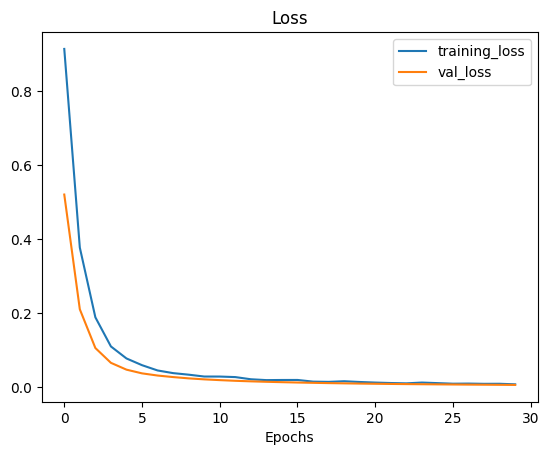

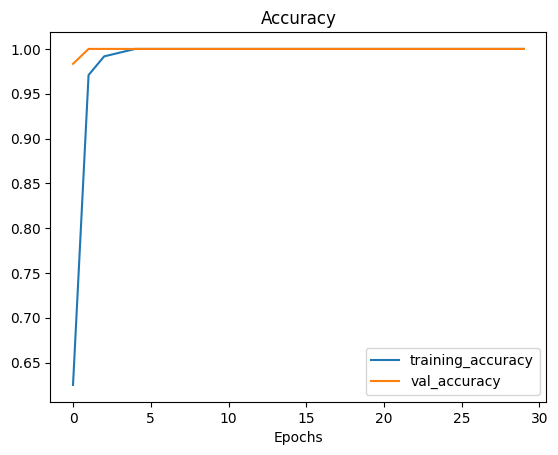

In [17]:
plot_loss_curves(batch2_model_1_history)

# Fine-tuning

In [18]:
# unfreez all of the layers in the base-model
base_model.trainable = True

# refreez every layer except the last five layers
for layer in base_model.layers[:-5]:
  layer.trainable = False

In [19]:
# recompile model with lower learning rate
batch2_model_1.compile(loss="categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              metrics=["accuracy"])

In [20]:
# what layers in the model trainable?
for layer in batch2_model_1.layers:
  print(layer.name, layer.trainable)

input_layer True
data_augmentation True
efficientnetb0 True
Global_average_pooling_layer True
output_layer True


In [21]:
# check which layers are trainable in our base-model
for layer_number, layer in enumerate(batch2_model_1.layers[2].layers):
  print(layer_number, layer.name, layer.trainable)

0 input_1 False
1 rescaling False
2 normalization False
3 stem_conv_pad False
4 stem_conv False
5 stem_bn False
6 stem_activation False
7 block1a_dwconv False
8 block1a_bn False
9 block1a_activation False
10 block1a_se_squeeze False
11 block1a_se_reshape False
12 block1a_se_reduce False
13 block1a_se_expand False
14 block1a_se_excite False
15 block1a_project_conv False
16 block1a_project_bn False
17 block2a_expand_conv False
18 block2a_expand_bn False
19 block2a_expand_activation False
20 block2a_dwconv_pad False
21 block2a_dwconv False
22 block2a_bn False
23 block2a_activation False
24 block2a_se_squeeze False
25 block2a_se_reshape False
26 block2a_se_reduce False
27 block2a_se_expand False
28 block2a_se_excite False
29 block2a_project_conv False
30 block2a_project_bn False
31 block2b_expand_conv False
32 block2b_expand_bn False
33 block2b_expand_activation False
34 block2b_dwconv False
35 block2b_bn False
36 block2b_activation False
37 block2b_se_squeeze False
38 block2b_se_reshape F

In [ ]:
# fine-tune for 5 more epochs
fine_tune_epochs = 60

# fine-tune our model
history_model_1_fine_tune = batch2_model_1.fit(train_data,
                                      epochs=fine_tune_epochs,
                                      validation_data=test_data,
                                      validation_steps=int(len(test_data)),
                                      initial_epoch=batch2_model_1_history.epoch[-1])

Epoch 30/60
8/8 [==============================] - 33s 955ms/step - loss: 0.0044 - accuracy: 1.0000 - val_loss: 0.0014 - val_accuracy: 1.0000
Epoch 31/60
8/8 [==============================] - 27s 1s/step - loss: 0.0015 - accuracy: 1.0000 - val_loss: 8.0276e-04 - val_accuracy: 1.0000
Epoch 32/60
8/8 [==============================] - 23s 772ms/step - loss: 0.0012 - accuracy: 1.0000 - val_loss: 2.1807e-04 - val_accuracy: 1.0000
Epoch 33/60
8/8 [==============================] - 25s 843ms/step - loss: 5.4579e-04 - accuracy: 1.0000 - val_loss: 1.1890e-04 - val_accuracy: 1.0000
Epoch 34/60
8/8 [==============================] - 25s 1s/step - loss: 1.0827e-04 - accuracy: 1.0000 - val_loss: 7.8503e-05 - val_accuracy: 1.0000
Epoch 35/60
8/8 [==============================] - 23s 815ms/step - loss: 1.5119e-04 - accuracy: 1.0000 - val_loss: 6.5986e-05 - val_accuracy: 1.0000
Epoch 36/60
8/8 [==============================] - 28s 910ms/step - loss: 1.5457e-04 - accuracy: 1.0000 - val_loss: 5.8833

In [ ]:
# evaluate on the wholes test data
model_1_fine_tune_results = batch2_model_1.evaluate(test_data)
model_1_fine_tune_results

2/2 [==============================] - 4s 2s/step - loss: 7.8198e-06 - accuracy: 1.0000


[7.819814527465496e-06, 1.0]

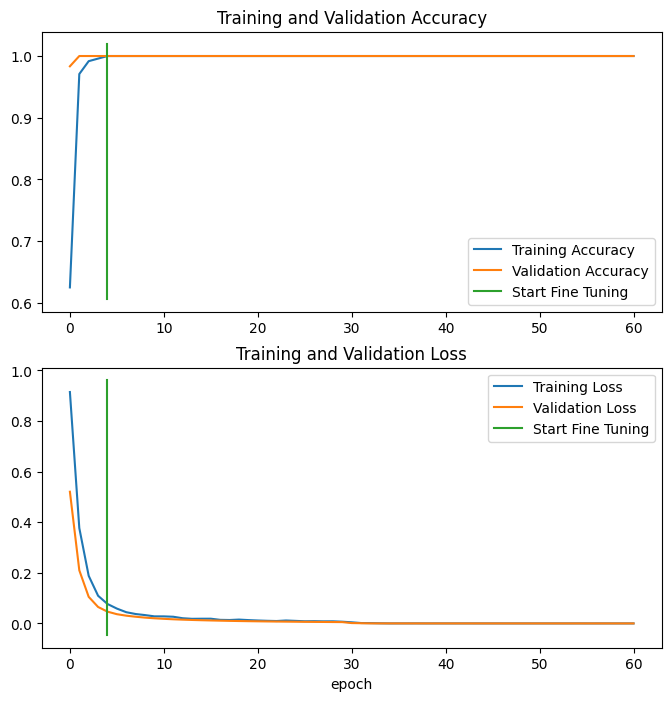

In [ ]:
# compare the histories of feature extraction model with fine-tuining model
compare_historys(original_history=batch2_model_1_history,
                 new_history=history_model_1_fine_tune,
                 initial_epochs=5)

# Saving model

In [ ]:
# save our fine-tuned model
batch2_model_1.save("batch2_model_1.h5")

# Making predictions with our trained model

In [ ]:
# make predictions
preds_probs = batch2_model_1.predict(test_data, verbose=1)

2/2 [==============================] - 5s 2s/step


In [ ]:
# how many predictions are there?
len(preds_probs)

60

In [ ]:
# what is the shape of our predictions
preds_probs.shape

(60, 3)

In [ ]:
# let's check the first 10 predictions looks like?
preds_probs[:10]

array([[9.9999118e-01, 3.2580569e-06, 5.5457785e-06],
       [9.9999642e-01, 1.5551400e-06, 2.0528357e-06],
       [9.9997056e-01, 4.6332757e-06, 2.4804691e-05],
       [9.9997044e-01, 5.7468465e-06, 2.3787010e-05],
       [9.9999499e-01, 1.5640112e-06, 3.4575430e-06],
       [9.9999988e-01, 5.0963781e-08, 1.6257259e-07],
       [9.9999988e-01, 5.9763664e-08, 2.9951721e-08],
       [9.9999964e-01, 1.4264097e-07, 2.6393064e-07],
       [1.0000000e+00, 3.6167766e-08, 3.3839349e-09],
       [9.9999964e-01, 2.8227242e-07, 1.3751429e-07]], dtype=float32)

In [ ]:
# get the pred classes of each label
pred_classes = preds_probs.argmax(axis=1)

# how do they look
pred_classes[:10]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [ ]:
# how many pred classes do we have
len(pred_classes)

60

In [ ]:
# to get our test labels we need to unravel our test_data BatchDataset
y_labels = []
for images, labels in test_data.unbatch():
  y_labels.append(labels.numpy().argmax()) # currently test labels look like: [0,0,0,1,0,...,0,0]
y_labels[:10]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

In [ ]:
# Let's try sklearn accuracy score function and see what it comes up with
from sklearn.metrics import accuracy_score
sklearn_accuracy = accuracy_score(y_true=y_labels,
                                  y_pred=pred_classes)

sklearn_accuracy

1.0

# Making confusion matrix

In [ ]:
import itertools
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix

# Our function needs a different name to sklearn's plot_confusion_matrix
def make_confusion_matrix(y_true, y_pred, classes=None, figsize=(10, 10), text_size=15, norm=False, savefig=False):
  """Makes a labelled confusion matrix comparing predictions and ground truth labels.

  If classes is passed, confusion matrix will be labelled, if not, integer class values
  will be used.

  Args:
    y_true: Array of truth labels (must be same shape as y_pred).
    y_pred: Array of predicted labels (must be same shape as y_true).
    classes: Array of class labels (e.g. string form). If `None`, integer labels are used.
    figsize: Size of output figure (default=(10, 10)).
    text_size: Size of output figure text (default=15).
    norm: normalize values or not (default=False).
    savefig: save confusion matrix to file (default=False).

  Returns:
    A labelled confusion matrix plot comparing y_true and y_pred.

  Example usage:
    make_confusion_matrix(y_true=test_labels, # ground truth test labels
                          y_pred=y_preds, # predicted labels
                          classes=class_names, # array of class label names
                          figsize=(15, 15),
                          text_size=10)
  """
  # Create the confustion matrix
  cm = confusion_matrix(y_true, y_pred)
  cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis] # normalize it
  n_classes = cm.shape[0] # find the number of classes we're dealing with

  # Plot the figure and make it pretty
  fig, ax = plt.subplots(figsize=figsize)
  cax = ax.matshow(cm, cmap=plt.cm.Blues) # colors will represent how 'correct' a class is, darker == better
  fig.colorbar(cax)

  # Are there a list of classes?
  if classes:
    labels = classes
  else:
    labels = np.arange(cm.shape[0])

  # Label the axes
  ax.set(title="Confusion Matrix",
         xlabel="Predicted label",
         ylabel="True label",
         xticks=np.arange(n_classes), # create enough axis slots for each class
         yticks=np.arange(n_classes),
         xticklabels=labels, # axes will labeled with class names (if they exist) or ints
         yticklabels=labels)

  # Make x-axis labels appear on bottom
  ax.xaxis.set_label_position("bottom")
  ax.xaxis.tick_bottom()

  ### changed (plot x-label vertically) ###
  plt.xticks(rotation=70, fontsize=text_size)
  plt.yticks(fontsize=text_size)

  # Set the threshold for different colors
  threshold = (cm.max() + cm.min()) / 2.

  # Plot the text on each cell
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    if norm:
      plt.text(j, i, f"{cm[i, j]} ({cm_norm[i, j]*100:.1f}%)",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)
    else:
      plt.text(j, i, f"{cm[i, j]}",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)

  # Save the figure to the current working directory
  if savefig:
    fig.savefig("confusion_matrix.png")

In [ ]:
make_confusion_matrix(y_true=y_labels,
                      y_pred=pred_classes,
                      classes=test_data.class_names,
                      figsize=(100,100),
                      text_size=20)

# Generate classification report

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_true=y_labels, y_pred=pred_classes))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        20
           1       1.00      1.00      1.00        20
           2       1.00      1.00      1.00        20

    accuracy                           1.00        60
   macro avg       1.00      1.00      1.00        60
weighted avg       1.00      1.00      1.00        60



In [ ]:
# get a dictionary of the classification report
classification_report_dict = classification_report(y_labels, pred_classes, output_dict=True)

# create empty dictionary
class_f1_scores = {}

# get class names from test data
class_names = test_data.class_names

# loop through classificationreport dictionary items
for k, v in classification_report_dict.items():
  if k == "accuracy":
    break
  else:
    class_f1_scores[class_names[int(k)]] = v["f1-score"]
class_f1_scores

In [ ]:
# turn f1-scores into dataframe for visualization
import pandas as pd
f1_scores = pd.DataFrame({"class_names": list(class_f1_scores.keys()),
                          "f1-score": list(class_f1_scores.values())}).sort_values("f1-score", ascending=False)

In [ ]:
f1_scores[:20]

In [ ]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(12, 25))
scores = ax.barh(range(len(f1_scores)), f1_scores["f1-score"].values)
ax.set_yticks(range(len(f1_scores)))
ax.set_yticklabels(f1_scores["class_names"])
ax.set_xlabel("F1-score")
ax.set_title("F1-scores for BATCH 1")
ax.invert_yaxis()

# Visualizing predictions on custom images

In [ ]:
# create a function to load and prepare images
def load_and_prep_image(filename, img_shape=224, scale=True):
  """
  Reads in an image from filename, turns it into a tensor and reshape into
  specified shape (img_shape, img_shape, color_channels=3)
  """

  # read the target image
  img = tf.io.read_file(filename)

  # decode image into tensor
  img = tf.io.decode_image(img, channels=3)

  # resize the image
  img = tf.image.resize(img, [img_shape, img_shape])

  # scale yes/no
  if scale:
    return img/255
  else:
    return img

In [ ]:
import os
import random

plt.figure(figsize=(20, 10))
for i in range(3):
  # choose random images(s) from a random classes
  class_name = random.choice(class_names)
  filename = random.choice(os.listdir(test_dir + "/" + class_name))
  filepath = test_dir + class_name + "/" + filename

  # load the image and make predictions
  img = load_and_prep_image(filepath, scale=False)
  img_expanded = tf.expand_dims(img, axis=0)
  pred_prob = batch2_model_1.predict(img_expanded)
  pred_class = class_names[pred_prob.argmax()]

  # plot the images
  plt.subplot(1, 3, i+1)
  plt.imshow(img/255.)
  if class_name == pred_class:
    title_color = "g"
  else:
    title_color = "r"
  plt.title(f"actual: {class_name}, pred: {pred_class}, prob: {pred_prob.max():.2f}", c=title_color)
  plt.axis(False)

# Test the model on custom images